In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import Birch
%matplotlib inline

## Imagen Original

Tamaño original :  (4032, 3024, 3)
Tamaño reducido :  (2016, 1512, 3)


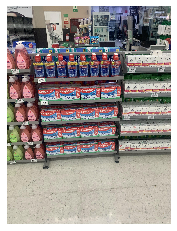

In [2]:
PATH = "../../data/JPEG/" 
image = cv2.imread(PATH+'IMG_2492.jpg')
print('Tamaño original : ', image.shape)
 
scale_percent = 50 
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
dim = (width, height)

resized_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
 
print('Tamaño reducido : ',resized_image.shape)
 
plt.axis("off")
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.show()

# Selección del objeto de interés

In [3]:
def rotate_image(image, angle):
  """
  Función rotar imagen

  Args:
  image
  angle

  Return:
  rotated_image
  """
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

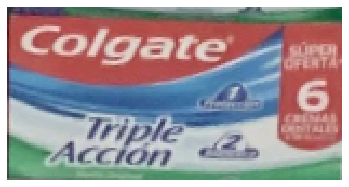

In [4]:
cropped = rotate_image(resized_image, -6)[int(2540*scale_percent/100):int(2700*scale_percent/100),                                         int(980*scale_percent/100):int(1290*scale_percent/100)]                

plt.axis("off")
plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
plt.show()

cv2.imwrite('Objeto.jpg', cropped);

# Detector SIFT

In [5]:
def sift_detector(new_image, image_template):
    """
    Detector SIFT, compara la imagen de referencia y la de estudio.
    Devuelve el número de características SIFT positivas en la comparación.

    Args:
    new_image
    image template

    Return:
    matches
    """
    
    image1 = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
    image2 = image_template

    # Crea el dectector de objetos SIFT
    sift = cv2.SIFT_create()
    # Obtiene los descriptores y puntos clave
    keypoints_1, descriptors_1 = sift.detectAndCompute(image1, None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(image2, None)

    # Define los parámetros del FLANN Matcher
    FLANN_INDEX_KDTREE = 4
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 3)
    search_params = dict(checks = 100)

    # Crea el objeto FLANN Matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Obtiene las comparaciones utilizando K-Nearest Neighbors
    matches = flann.knnMatch(descriptors_1, descriptors_2, k=2)

    # Almacena las comparaciones correctas con el ratio de Lowetest
    good_matches = []
    for m,n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m) 
    return len(good_matches)

# Detección y conteo de los objetos de interés

In [6]:
image_template = cropped
input_image = resized_image

In [7]:
height, width = image_template.shape[:2]
prob_width, prob_height = int(width*1.5), int(height*1.5)

In [8]:
x_detect=[]
y_detect=[]
score = []
threshold = 30
counter = 0

for y in range(0, input_image.shape[0]-height, int(min(image_template.shape[:2])/3)):
    for x in range(0, input_image.shape[1]-width, int(min(image_template.shape[:2])/3)):
        temp_img = input_image[y:y+height, x:x+width]
        matches = sift_detector(temp_img, image_template)
        if matches >= threshold:
            x_detect.append(x)
            y_detect.append(y)
            score.append(matches)
            counter += 1

## Clusterización

In [9]:
lista = np.array(list(zip(x_detect, y_detect)))
clustering = Birch(threshold=min(image_template.shape[:2])*0.85 , n_clusters=None).fit(lista)

In [10]:
centroids = []
for each in np.unique(clustering.labels_):
    centroids.append(lista[clustering.labels_ == each].sum(axis=0)/len(lista[clustering.labels_ == each]))

In [11]:
for x, y in centroids:
    x = int(x)
    y = int(y)
    cv2.rectangle(input_image, (x, y), (x+width, y+height), (0,255,0), 3)

## Resultados

El número de objetos detectados antes de la clusterización es :  304
El número de objetos detectados es :  18


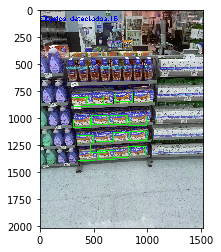

In [12]:
print(f'El número de objetos detectados antes de la clusterización es : ', str(counter))
print(f'El número de objetos detectados es : ', str(len(centroids)))

font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(input_image,'Objetos detectados:'+str(len(centroids)),(10,100), font, 2,(0,0,255),6)

plt.imshow(input_image)
plt.show()

cv2.imwrite('SIFT_DETECTION.jpg', input_image);